In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#| Conjunto | Instância pequena | Instância média | Instância grande |
#| -------- | ----------------- | --------------- | ---------------- |
#| **A**    | A-n32-k5.vrp      | A-n53-k7.vrp    | A-n80-k10.vrp    |
#| **B**    | B-n31-k5.vrp      | B-n50-k7.vrp    | B-n78-k10.vrp    |
#| **E**    | E-n13-k4.vrp      | E-n51-k5.vrp    | E-n101-k14.vrp   |
#| **F**    | F-n45-k4.vrp      | F-n72-k4.vrp    | F-n135-k7.vrp    |
#| **P**    | P-n16-k8.vrp      | P-n55-k10.vrp   | P-n101-k4.vrp    |


In [ ]:
import os, math, random, csv, argparse, json
from copy import deepcopy

# ===========================
# PARSER do arquivo VRP
# ===========================
def ler_vrp(caminho):
    coordenadas = {}
    demanda = {}
    deposito = None
    capacidade = None

    with open(caminho,'r') as f:
        linhas=[l.strip() for l in f]

    secao=None
    for ln in linhas:
        if ln.startswith("CAPACITY"):
            capacidade = int(ln.split(":")[-1])
        if ln.startswith("NODE_COORD_SECTION"):
            secao="NO"; continue
        if ln.startswith("DEMAND_SECTION"):
            secao="DEMANDA"; continue
        if ln.startswith("DEPOT_SECTION"):
            secao="DEPOSITO"; continue
        if ln.startswith("EOF"):
            break

        if secao=="NO":
            partes=ln.split()
            if len(partes)==3:
                nid,x,y = partes
                coordenadas[int(nid)]=(float(x),float(y))

        elif secao=="DEMANDA":
            partes=ln.split()
            if len(partes)==2:
                nid,d = partes
                demanda[int(nid)]=float(d)

        elif secao=="DEPOSITO":
            if ln not in ["DEPOT_SECTION","-1"]:
                try: deposito=int(ln)
                except: pass

    if deposito is None: deposito=1
    return coordenadas,demanda,deposito,capacidade


# ===========================
# FUNÇÕES VRP
# ===========================
def euclidiana(a, b):
    return int(round(math.hypot(a[0] - b[0], a[1] - b[1])))

def custo_rota(rota,coordenadas):
    return sum(euclidiana(coordenadas[rota[i]],coordenadas[rota[i+1]]) for i in range(len(rota)-1))

def dividir_capacidade(tour,coords,demanda,deposito,cap):
    rotas=[]
    r=[deposito]; carga=0
    for c in tour:
        d=demanda[c]
        if carga+d>cap and len(r)>1:
            r.append(deposito); rotas.append(r)
            r=[deposito,c]; carga=d
        else:
            r.append(c); carga+=d
    r.append(deposito); rotas.append(r)
    return sum(custo_rota(rt,coords) for rt in rotas)


# ===========================
# ALGORITMO GENÉTICO
# ===========================
def mutar(p):
    a,b=random.sample(range(len(p)),2)
    p[a],p[b]=p[b],p[a]

# Seleções
def roleta(pop,fit):
    inv=[1/(f+1e-9) for f in fit]
    return deepcopy(random.choices(pop,weights=inv)[0])

def selecao_rank(pop,fit):
    r=sorted(range(len(fit)),key=lambda i:fit[i])
    return deepcopy(pop[random.choices(r,weights=range(1,len(pop)+1))[0]])

def elitista(pop,fit):
    return deepcopy(pop[min(range(len(pop)),key=lambda i:fit[i])])

def torneio(pop,fit,k=3):
    s=random.sample(range(len(pop)),k)
    return deepcopy(pop[min(s,key=lambda i:fit[i])])


# ===========================
# CROSSOVERS
# ===========================
def cruzamento_pmx(a,b):
    n=len(a); c=[-1]*n
    p1,p2=sorted(random.sample(range(n),2))
    c[p1:p2]=a[p1:p2]
    for i in range(p1,p2):
        if b[i] not in c:
            v=b[i]; j=i
            while True:
                v2=a[j]; j=b.index(v2)
                if c[j]==-1:
                    c[j]=v; break
    for i in range(n):
        if c[i]==-1: c[i]=b[i]
    return c

def cruzamento_ox(a,b):
    n=len(a); p1,p2=sorted(random.sample(range(n),2))
    c=[None]*n; c[p1:p2]=a[p1:p2]
    resto=[x for x in b if x not in c]; j=0
    for i in range(n):
        if c[i] is None: c[i]=resto[j]; j+=1
    return c

def cruzamento_cx(a,b):
    n=len(a); c=[None]*n; inicio=0
    while None in c:
        i=inicio; ciclo=[]
        while i not in ciclo:
            ciclo.append(i)
            i=b.index(a[i])
        for x in ciclo: c[x]=a[x]
        inicio=[i for i,x in enumerate(c) if x is None]
        if not inicio: break
        inicio=inicio[0]
    for i in range(n):
        if c[i] is None: c[i]=b[i]
    return c

def cruzamento_aex(a,b):
    n=len(a); c=[None]*n; usado=set()
    atual=a[0]; c[0]=atual; usado.add(atual)
    for i in range(1,n):
        sa=a[(a.index(atual)+1)%n]
        sb=b[(b.index(atual)+1)%n]
        prox=sb if random.random()<0.5 else sa
        if prox in usado: prox=random.choice([x for x in a if x not in usado])
        c[i]=prox; usado.add(prox); atual=prox
    return c

def cruzamento_erx(a,b):
    n=len(a); adj={x:set() for x in a}
    for pai in (a,b):
        for i,x in enumerate(pai):
            adj[x].update([pai[(i-1)%n],pai[(i+1)%n]])
    atual=random.choice(a); c=[atual]; usado={atual}
    while len(c)<n:
        for v in adj.values(): v.discard(atual)
        if adj[atual]:
            prox=min(adj[atual],key=lambda x:len(adj[x]))
            if prox in usado: prox=None
        else: prox=None
        if prox is None: prox=random.choice([x for x in a if x not in usado])
        c.append(prox); usado.add(prox); atual=prox
    return c


# ===========================
# ACMSF PRINCIPAL
# ===========================
def executar_acmsf(caminho, bks=None, seed=1):
    random.seed(seed)
    coords,demanda,deposito,capacidade = ler_vrp(caminho)
    clientes = [i for i in coords if i != deposito]

    POP = 100
    GER = 1000

    selecoes = [
        ("roleta",   roleta),
        ("rank",     selecao_rank),
        ("elitismo", elitista),
        ("torneio",  torneio)
    ]

    crossovers = [
        ("pmx", cruzamento_pmx),
        ("ox",  cruzamento_ox),
        ("cx",  cruzamento_cx),
        ("aex", cruzamento_aex),
        ("erx", cruzamento_erx)
    ]

    resultados = []

    # dicionários para acumular desvios
    desvios_por_sel   = {nome: [] for nome, _ in selecoes}
    desvios_por_cross = {nome: [] for nome, _ in crossovers}

    for s_nome, S in selecoes:
        for c_nome, C in crossovers:
            populacao = [random.sample(clientes, len(clientes)) for _ in range(POP)]

            for _ in range(GER):
                custos = [dividir_capacidade(p, coords, demanda, deposito, capacidade)
                          for p in populacao]

                elite = sorted(
                    populacao,
                    key=lambda x: dividir_capacidade(x, coords, demanda, deposito, capacidade)
                )[:40]

                nova = elite[:]

                while len(nova) < 90:
                    nova.append(C(S(populacao, custos), S(populacao, custos)))
                while len(nova) < 100:
                    r = S(populacao, custos)
                    mutar(r)
                    nova.append(r)

                populacao = nova

            # custo final da combinação
            custos = [dividir_capacidade(p, coords, demanda, deposito, capacidade)
                      for p in populacao]

            melhor = min(custos)
            melhor_indice = custos.index(melhor)
            melhor_tour = populacao[melhor_indice]

            desvio = (melhor/bks - 1)*100 if bks else None

            resultados.append((s_nome, c_nome, melhor, desvio))
            print(s_nome, "x", c_nome, "→", melhor, "desvio:", round(desvio, 2))
            #print("MELHOR TOUR:", melhor_tour)

            # 🔹 acumula desvio para média
            if desvio is not None:
                desvios_por_sel[s_nome].append(desvio)
                desvios_por_cross[c_nome].append(desvio)

    # calcular médias por seleção
    medias_sel = {}
    print("\n=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===")
    for s_nome, valores in desvios_por_sel.items():
        if valores:
            media = sum(valores)/len(valores)
            medias_sel[s_nome] = media
            print(f"{s_nome}: {media:.2f}% (baseado em {len(valores)} valores)")
        else:
            medias_sel[s_nome] = None
            print(f"{s_nome}: sem valores")

    # calcular médias por crossover
    medias_cross = {}
    print("\n=== MÉDIA DE DESVIO POR CROSSOVER ===")
    for c_nome, valores in desvios_por_cross.items():
        if valores:
            media = sum(valores)/len(valores)
            medias_cross[c_nome] = media
            print(f"{c_nome}: {media:.2f}% (baseado em {len(valores)} valores)")
        else:
            medias_cross[c_nome] = None
            print(f"{c_nome}: sem valores")



# Pequenas instâncias

In [ ]:
executar_acmsf("/content/drive/MyDrive/Small/A-n32-k5.vrp", bks=784)

roleta x pmx → 991 desvio: 26.4
roleta x ox → 949 desvio: 21.05
roleta x cx → 989 desvio: 26.15
roleta x aex → 908 desvio: 15.82
roleta x erx → 844 desvio: 7.65
rank x pmx → 1045 desvio: 33.29
rank x ox → 993 desvio: 26.66
rank x cx → 1070 desvio: 36.48
rank x aex → 1181 desvio: 50.64
rank x erx → 1040 desvio: 32.65
elitismo x pmx → 969 desvio: 23.6
elitismo x ox → 966 desvio: 23.21
elitismo x cx → 962 desvio: 22.7
elitismo x aex → 974 desvio: 24.23
elitismo x erx → 952 desvio: 21.43
torneio x pmx → 969 desvio: 23.6
torneio x ox → 947 desvio: 20.79
torneio x cx → 1142 desvio: 45.66
torneio x aex → 819 desvio: 4.46
torneio x erx → 827 desvio: 5.48

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 19.41% (baseado em 5 valores)
rank: 35.94% (baseado em 5 valores)
elitismo: 23.04% (baseado em 5 valores)
torneio: 20.00% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 26.72% (baseado em 4 valores)
ox: 22.93% (baseado em 4 valores)
cx: 32.75% (baseado em 4 valores)
aex

In [ ]:
executar_acmsf("/content/drive/MyDrive/Small/B-n31-k5.vrp", bks=675)

roleta x pmx → 755 desvio: 11.85
roleta x ox → 726 desvio: 7.56
roleta x cx → 719 desvio: 6.52
roleta x aex → 687 desvio: 1.78
roleta x erx → 676 desvio: 0.15
rank x pmx → 717 desvio: 6.22
rank x ox → 727 desvio: 7.7
rank x cx → 770 desvio: 14.07
rank x aex → 797 desvio: 18.07
rank x erx → 721 desvio: 6.81
elitismo x pmx → 861 desvio: 27.56
elitismo x ox → 826 desvio: 22.37
elitismo x cx → 831 desvio: 23.11
elitismo x aex → 771 desvio: 14.22
elitismo x erx → 729 desvio: 8.0
torneio x pmx → 700 desvio: 3.7
torneio x ox → 760 desvio: 12.59
torneio x cx → 763 desvio: 13.04
torneio x aex → 711 desvio: 5.33
torneio x erx → 672 desvio: -0.44

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 5.57% (baseado em 5 valores)
rank: 10.58% (baseado em 5 valores)
elitismo: 19.05% (baseado em 5 valores)
torneio: 6.84% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 12.33% (baseado em 4 valores)
ox: 12.56% (baseado em 4 valores)
cx: 14.19% (baseado em 4 valores)
aex: 9.85% (base

In [ ]:
executar_acmsf("/content/drive/MyDrive/Small/E-n22-k4.vrp", bks=375)

roleta x pmx → 393 desvio: 4.8
roleta x ox → 413 desvio: 10.13
roleta x cx → 445 desvio: 18.67
roleta x aex → 393 desvio: 4.8
roleta x erx → 375 desvio: 0.0
rank x pmx → 421 desvio: 12.27
rank x ox → 375 desvio: 0.0
rank x cx → 413 desvio: 10.13
rank x aex → 494 desvio: 31.73
rank x erx → 421 desvio: 12.27
elitismo x pmx → 454 desvio: 21.07
elitismo x ox → 424 desvio: 13.07
elitismo x cx → 439 desvio: 17.07
elitismo x aex → 441 desvio: 17.6
elitismo x erx → 460 desvio: 22.67
torneio x pmx → 387 desvio: 3.2
torneio x ox → 430 desvio: 14.67
torneio x cx → 401 desvio: 6.93
torneio x aex → 388 desvio: 3.47
torneio x erx → 383 desvio: 2.13

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 7.68% (baseado em 5 valores)
rank: 13.28% (baseado em 5 valores)
elitismo: 18.29% (baseado em 5 valores)
torneio: 6.08% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 10.33% (baseado em 4 valores)
ox: 9.47% (baseado em 4 valores)
cx: 13.20% (baseado em 4 valores)
aex: 14.40% (basea

In [ ]:
executar_acmsf("/content/drive/MyDrive/Small/F-n45-k4.vrp", bks=724)

roleta x pmx → 854 desvio: 17.96
roleta x ox → 882 desvio: 21.82
roleta x cx → 847 desvio: 16.99
roleta x aex → 812 desvio: 12.15
roleta x erx → 774 desvio: 6.91
rank x pmx → 1128 desvio: 55.8
rank x ox → 1143 desvio: 57.87
rank x cx → 1078 desvio: 48.9
rank x aex → 1354 desvio: 87.02
rank x erx → 1144 desvio: 58.01
elitismo x pmx → 998 desvio: 37.85
elitismo x ox → 1059 desvio: 46.27
elitismo x cx → 1000 desvio: 38.12
elitismo x aex → 1003 desvio: 38.54
elitismo x erx → 850 desvio: 17.4
torneio x pmx → 1058 desvio: 46.13
torneio x ox → 983 desvio: 35.77
torneio x cx → 964 desvio: 33.15
torneio x aex → 936 desvio: 29.28
torneio x erx → 860 desvio: 18.78

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 15.17% (baseado em 5 valores)
rank: 61.52% (baseado em 5 valores)
elitismo: 35.64% (baseado em 5 valores)
torneio: 32.62% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 39.43% (baseado em 4 valores)
ox: 40.44% (baseado em 4 valores)
cx: 34.29% (baseado em 4 valor

In [ ]:
executar_acmsf("/content/drive/MyDrive/Small/P-n40-k5.vrp", bks=458)

roleta x pmx → 609 desvio: 32.97
roleta x ox → 535 desvio: 16.81
roleta x cx → 687 desvio: 50.0
roleta x aex → 616 desvio: 34.5
roleta x erx → 504 desvio: 10.04
rank x pmx → 700 desvio: 52.84
rank x ox → 679 desvio: 48.25
rank x cx → 703 desvio: 53.49
rank x aex → 846 desvio: 84.72
rank x erx → 675 desvio: 47.38
elitismo x pmx → 597 desvio: 30.35
elitismo x ox → 574 desvio: 25.33
elitismo x cx → 535 desvio: 16.81
elitismo x aex → 576 desvio: 25.76
elitismo x erx → 601 desvio: 31.22
torneio x pmx → 569 desvio: 24.24
torneio x ox → 561 desvio: 22.49
torneio x cx → 568 desvio: 24.02
torneio x aex → 503 desvio: 9.83
torneio x erx → 481 desvio: 5.02

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 28.86% (baseado em 5 valores)
rank: 57.34% (baseado em 5 valores)
elitismo: 25.90% (baseado em 5 valores)
torneio: 17.12% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 35.10% (baseado em 4 valores)
ox: 28.22% (baseado em 4 valores)
cx: 36.08% (baseado em 4 valores)
aex: 

# Medias instâncias

In [ ]:
executar_acmsf("/content/drive/MyDrive/Medium/A-n55-k9.vrp", bks=1073)

roleta x pmx → 1267 desvio: 18.08
roleta x ox → 1356 desvio: 26.37
roleta x cx → 1545 desvio: 43.99
roleta x aex → 1400 desvio: 30.48
roleta x erx → 1265 desvio: 17.89
rank x pmx → 1679 desvio: 56.48
rank x ox → 1822 desvio: 69.8
rank x cx → 1840 desvio: 71.48
rank x aex → 2110 desvio: 96.64
rank x erx → 1635 desvio: 52.38
elitismo x pmx → 1463 desvio: 36.35
elitismo x ox → 1296 desvio: 20.78
elitismo x cx → 1435 desvio: 33.74
elitismo x aex → 1340 desvio: 24.88
elitismo x erx → 1444 desvio: 34.58
torneio x pmx → 1372 desvio: 27.87
torneio x ox → 1486 desvio: 38.49
torneio x cx → 1354 desvio: 26.19
torneio x aex → 1222 desvio: 13.89
torneio x erx → 1268 desvio: 18.17

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 27.36% (baseado em 5 valores)
rank: 69.36% (baseado em 5 valores)
elitismo: 30.07% (baseado em 5 valores)
torneio: 24.92% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 34.69% (baseado em 4 valores)
ox: 38.86% (baseado em 4 valores)
cx: 43.85% (base

In [ ]:
executar_acmsf("/content/drive/MyDrive/Medium/B-n57-k9.vrp", bks=1598)

roleta x pmx → 1790 desvio: 12.02
roleta x ox → 1759 desvio: 10.08
roleta x cx → 2047 desvio: 28.1
roleta x aex → 1878 desvio: 17.52
roleta x erx → 1760 desvio: 10.14
rank x pmx → 2162 desvio: 35.29
rank x ox → 2384 desvio: 49.19
rank x cx → 2272 desvio: 42.18
rank x aex → 2482 desvio: 55.32
rank x erx → 2084 desvio: 30.41
elitismo x pmx → 1811 desvio: 13.33
elitismo x ox → 1888 desvio: 18.15
elitismo x cx → 2012 desvio: 25.91
elitismo x aex → 2005 desvio: 25.47
elitismo x erx → 1904 desvio: 19.15
torneio x pmx → 1866 desvio: 16.77
torneio x ox → 1871 desvio: 17.08
torneio x cx → 1904 desvio: 19.15
torneio x aex → 1871 desvio: 17.08
torneio x erx → 1759 desvio: 10.08

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 15.57% (baseado em 5 valores)
rank: 42.48% (baseado em 5 valores)
elitismo: 20.40% (baseado em 5 valores)
torneio: 16.03% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 19.35% (baseado em 4 valores)
ox: 23.62% (baseado em 4 valores)
cx: 28.83% (base

In [ ]:
executar_acmsf("/content/drive/MyDrive/Medium/E-n51-k5.vrp", bks=521)

roleta x pmx → 795 desvio: 52.59
roleta x ox → 663 desvio: 27.26
roleta x cx → 788 desvio: 51.25
roleta x aex → 650 desvio: 24.76
roleta x erx → 591 desvio: 13.44
rank x pmx → 878 desvio: 68.52
rank x ox → 883 desvio: 69.48
rank x cx → 968 desvio: 85.8
rank x aex → 1130 desvio: 116.89
rank x erx → 833 desvio: 59.88
elitismo x pmx → 683 desvio: 31.09
elitismo x ox → 761 desvio: 46.07
elitismo x cx → 653 desvio: 25.34
elitismo x aex → 730 desvio: 40.12
elitismo x erx → 770 desvio: 47.79
torneio x pmx → 744 desvio: 42.8
torneio x ox → 740 desvio: 42.03
torneio x cx → 687 desvio: 31.86
torneio x aex → 706 desvio: 35.51
torneio x erx → 615 desvio: 18.04

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 33.86% (baseado em 5 valores)
rank: 80.12% (baseado em 5 valores)
elitismo: 38.08% (baseado em 5 valores)
torneio: 34.05% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 48.75% (baseado em 4 valores)
ox: 46.21% (baseado em 4 valores)
cx: 48.56% (baseado em 4 valores)
a

In [ ]:
executar_acmsf("/content/drive/MyDrive/Medium/F-n72-k4.vrp", bks=237)

roleta x pmx → 443 desvio: 86.92
roleta x ox → 383 desvio: 61.6
roleta x cx → 483 desvio: 103.8
roleta x aex → 403 desvio: 70.04
roleta x erx → 340 desvio: 43.46
rank x pmx → 640 desvio: 170.04
rank x ox → 649 desvio: 173.84
rank x cx → 701 desvio: 195.78
rank x aex → 838 desvio: 253.59
rank x erx → 514 desvio: 116.88
elitismo x pmx → 434 desvio: 83.12
elitismo x ox → 404 desvio: 70.46
elitismo x cx → 442 desvio: 86.5
elitismo x aex → 434 desvio: 83.12
elitismo x erx → 498 desvio: 110.13
torneio x pmx → 429 desvio: 81.01
torneio x ox → 439 desvio: 85.23
torneio x cx → 434 desvio: 83.12
torneio x aex → 376 desvio: 58.65
torneio x erx → 298 desvio: 25.74

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 73.16% (baseado em 5 valores)
rank: 182.03% (baseado em 5 valores)
elitismo: 86.67% (baseado em 5 valores)
torneio: 66.75% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 105.27% (baseado em 4 valores)
ox: 97.78% (baseado em 4 valores)
cx: 117.30% (baseado em 4 val

In [ ]:
executar_acmsf("/content/drive/MyDrive/Medium/P-n55-k7.vrp", bks=568)

roleta x pmx → 673 desvio: 18.49
roleta x ox → 664 desvio: 16.9
roleta x cx → 826 desvio: 45.42
roleta x aex → 814 desvio: 43.31
roleta x erx → 651 desvio: 14.61
rank x pmx → 856 desvio: 50.7
rank x ox → 988 desvio: 73.94
rank x cx → 1050 desvio: 84.86
rank x aex → 1173 desvio: 106.51
rank x erx → 907 desvio: 59.68
elitismo x pmx → 777 desvio: 36.8
elitismo x ox → 776 desvio: 36.62
elitismo x cx → 765 desvio: 34.68
elitismo x aex → 748 desvio: 31.69
elitismo x erx → 743 desvio: 30.81
torneio x pmx → 778 desvio: 36.97
torneio x ox → 743 desvio: 30.81
torneio x cx → 754 desvio: 32.75
torneio x aex → 678 desvio: 19.37
torneio x erx → 655 desvio: 15.32

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 27.75% (baseado em 5 valores)
rank: 75.14% (baseado em 5 valores)
elitismo: 34.12% (baseado em 5 valores)
torneio: 27.04% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 35.74% (baseado em 4 valores)
ox: 39.57% (baseado em 4 valores)
cx: 49.43% (baseado em 4 valores)
a

In [ ]:
executar_acmsf("E-n33-k4.vrp", bks=835)


roleta x pmx → 1003 desvio: 20.12
roleta x ox → 954 desvio: 14.25
roleta x cx → 943 desvio: 12.93
roleta x aex → 906 desvio: 8.5
roleta x erx → 873 desvio: 4.55
rank x pmx → 1000 desvio: 19.76
rank x ox → 1022 desvio: 22.4
rank x cx → 996 desvio: 19.28
rank x aex → 1151 desvio: 37.84
rank x erx → 1017 desvio: 21.8
elitismo x pmx → 983 desvio: 17.72
elitismo x ox → 997 desvio: 19.4
elitismo x cx → 1013 desvio: 21.32
elitismo x aex → 911 desvio: 9.1
elitismo x erx → 921 desvio: 10.3
torneio x pmx → 974 desvio: 16.65
torneio x ox → 907 desvio: 8.62
torneio x cx → 911 desvio: 9.1
torneio x aex → 926 desvio: 10.9
torneio x erx → 856 desvio: 2.51

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 12.07% (baseado em 5 valores)
rank: 24.22% (baseado em 5 valores)
elitismo: 15.57% (baseado em 5 valores)
torneio: 9.56% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 18.56% (baseado em 4 valores)
ox: 16.17% (baseado em 4 valores)
cx: 15.66% (baseado em 4 valores)
aex: 16.59

In [ ]:
executar_acmsf("/content/drive/MyDrive/Large/A-n80-k10.vrp", bks=1763)

roleta x pmx → 2221 desvio: 25.98
roleta x ox → 2271 desvio: 28.81
roleta x cx → 2517 desvio: 42.77
roleta x aex → 2859 desvio: 62.17
roleta x erx → 2378 desvio: 34.88
rank x pmx → 3081 desvio: 74.76
rank x ox → 3390 desvio: 92.29
rank x cx → 3378 desvio: 91.61
rank x aex → 3584 desvio: 103.29
rank x erx → 3289 desvio: 86.56
elitismo x pmx → 2320 desvio: 31.59
elitismo x ox → 2472 desvio: 40.22
elitismo x cx → 2305 desvio: 30.74
elitismo x aex → 2423 desvio: 37.44
elitismo x erx → 2287 desvio: 29.72
torneio x pmx → 2360 desvio: 33.86
torneio x ox → 2235 desvio: 26.77
torneio x cx → 2266 desvio: 28.53
torneio x aex → 2221 desvio: 25.98
torneio x erx → 2211 desvio: 25.41

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 38.92% (baseado em 5 valores)
rank: 89.70% (baseado em 5 valores)
elitismo: 33.94% (baseado em 5 valores)
torneio: 28.11% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 41.55% (baseado em 4 valores)
ox: 47.02% (baseado em 4 valores)
cx: 48.41% (ba

# Grandes

In [ ]:
executar_acmsf("/content/drive/MyDrive/Large/B-n78-k10.vrp", bks=1221)

roleta x pmx → 1801 desvio: 47.5
roleta x ox → 1780 desvio: 45.78
roleta x cx → 1843 desvio: 50.94
roleta x aex → 1961 desvio: 60.61
roleta x erx → 1582 desvio: 29.57
rank x pmx → 2563 desvio: 109.91
rank x ox → 2593 desvio: 112.37
rank x cx → 2458 desvio: 101.31
rank x aex → 2938 desvio: 140.62
rank x erx → 2325 desvio: 90.42
elitismo x pmx → 1898 desvio: 55.45
elitismo x ox → 1687 desvio: 38.17
elitismo x cx → 1796 desvio: 47.09
elitismo x aex → 1787 desvio: 46.36
elitismo x erx → 1686 desvio: 38.08
torneio x pmx → 1778 desvio: 45.62
torneio x ox → 1773 desvio: 45.21
torneio x cx → 1646 desvio: 34.81
torneio x aex → 1745 desvio: 42.92
torneio x erx → 1578 desvio: 29.24

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 46.88% (baseado em 5 valores)
rank: 110.93% (baseado em 5 valores)
elitismo: 45.03% (baseado em 5 valores)
torneio: 39.56% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 64.62% (baseado em 4 valores)
ox: 60.38% (baseado em 4 valores)
cx: 58.54% 

In [ ]:
executar_acmsf("/content/drive/MyDrive/Large/E-n101-k14.vrp", bks=1071)

roleta x pmx → 1682 desvio: 57.05
roleta x ox → 1520 desvio: 41.92
roleta x cx → 1757 desvio: 64.05
roleta x aex → 1997 desvio: 86.46
roleta x erx → 1636 desvio: 52.75
rank x pmx → 2415 desvio: 125.49
rank x ox → 2287 desvio: 113.54
rank x cx → 2490 desvio: 132.49
rank x aex → 2767 desvio: 158.36
rank x erx → 2267 desvio: 111.67
elitismo x pmx → 1503 desvio: 40.34
elitismo x ox → 1585 desvio: 47.99
elitismo x cx → 1578 desvio: 47.34
elitismo x aex → 1703 desvio: 59.01
elitismo x erx → 1798 desvio: 67.88
torneio x pmx → 1575 desvio: 47.06
torneio x ox → 1556 desvio: 45.28
torneio x cx → 1706 desvio: 59.29
torneio x aex → 1633 desvio: 52.47
torneio x erx → 1528 desvio: 42.67

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 60.45% (baseado em 5 valores)
rank: 128.31% (baseado em 5 valores)
elitismo: 52.51% (baseado em 5 valores)
torneio: 49.36% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 67.48% (baseado em 4 valores)
ox: 62.18% (baseado em 4 valores)
cx: 75.79

In [ ]:
executar_acmsf("/content/drive/MyDrive/Large/F-n135-k7.vrp", bks=1162)

roleta x pmx → 2556 desvio: 119.97
roleta x ox → 1990 desvio: 71.26
roleta x cx → 2805 desvio: 141.39
roleta x aex → 3046 desvio: 162.13
roleta x erx → 2181 desvio: 87.69
rank x pmx → 3489 desvio: 200.26
rank x ox → 4098 desvio: 252.67
rank x cx → 4188 desvio: 260.41
rank x aex → 4745 desvio: 308.35
rank x erx → 3308 desvio: 184.68
elitismo x pmx → 2504 desvio: 115.49
elitismo x ox → 2359 desvio: 103.01
elitismo x cx → 2160 desvio: 85.89
elitismo x aex → 2294 desvio: 97.42
elitismo x erx → 2378 desvio: 104.65
torneio x pmx → 2464 desvio: 112.05
torneio x ox → 2101 desvio: 80.81
torneio x cx → 2882 desvio: 148.02
torneio x aex → 2160 desvio: 85.89
torneio x erx → 2175 desvio: 87.18

=== MÉDIA DE DESVIO POR MÉTODO DE SELEÇÃO ===
roleta: 116.49% (baseado em 5 valores)
rank: 241.27% (baseado em 5 valores)
elitismo: 101.29% (baseado em 5 valores)
torneio: 102.79% (baseado em 5 valores)

=== MÉDIA DE DESVIO POR CROSSOVER ===
pmx: 136.94% (baseado em 4 valores)
ox: 126.94% (baseado em 4 valor

Gráfico salvo: selecao_small.png


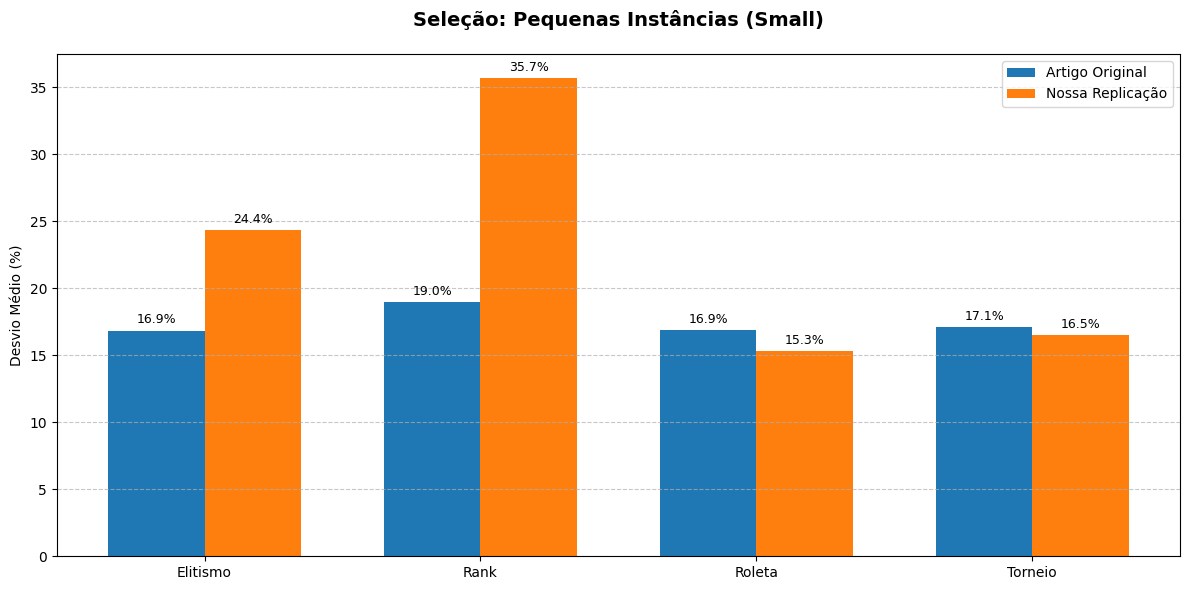

Gráfico salvo: crossover_small.png


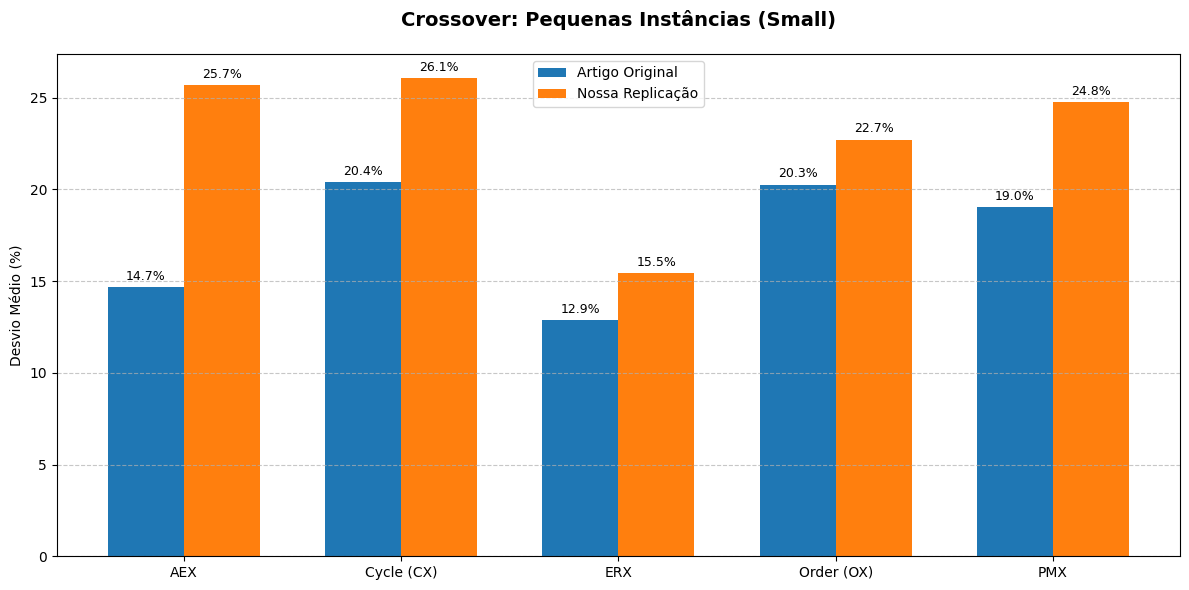

Gráfico salvo: selecao_medium.png


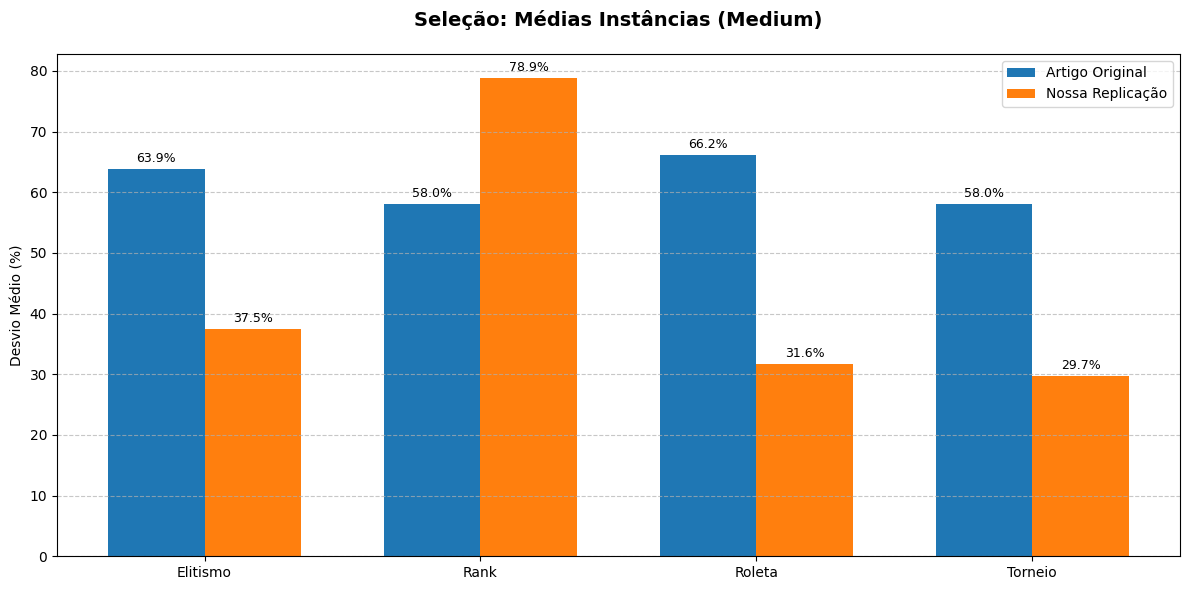

Gráfico salvo: crossover_medium.png


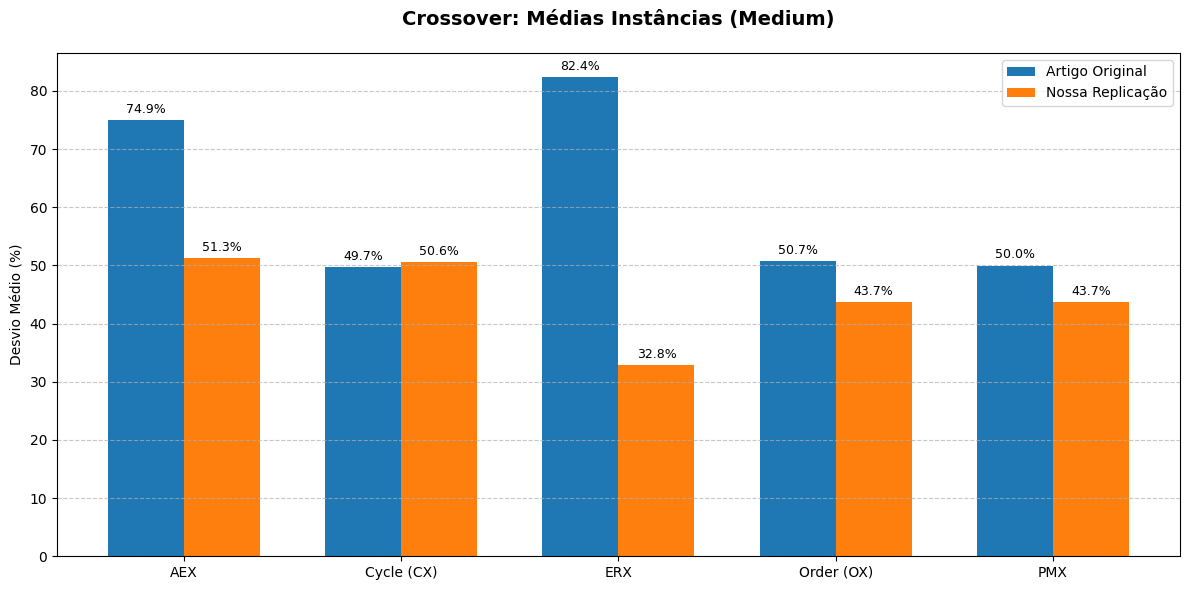

Gráfico salvo: selecao_large.png


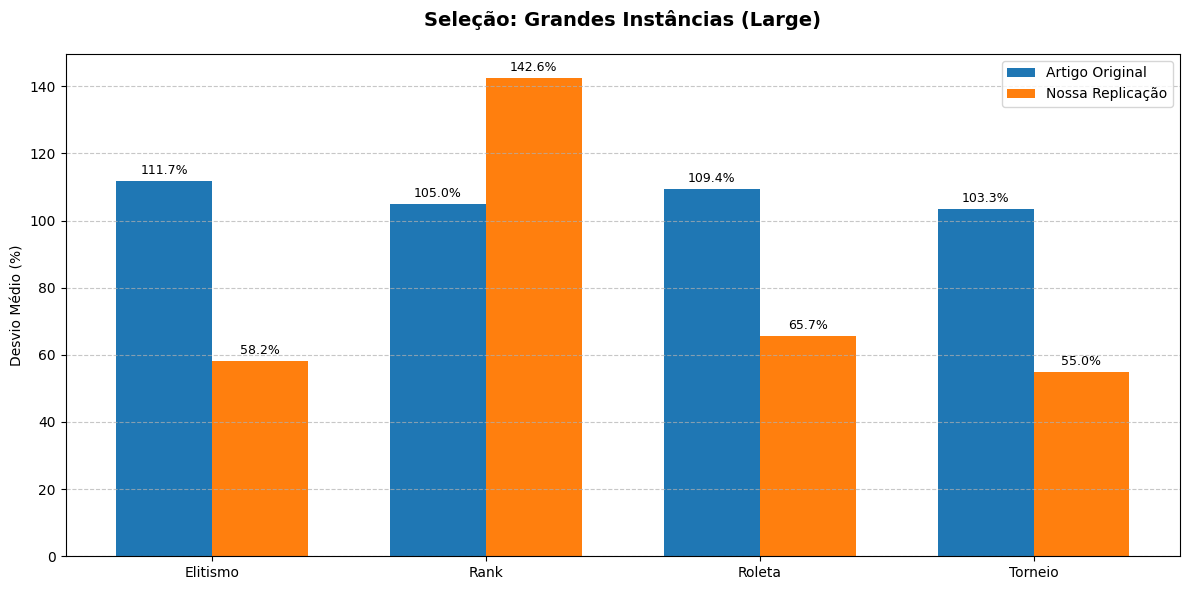

Gráfico salvo: crossover_large.png


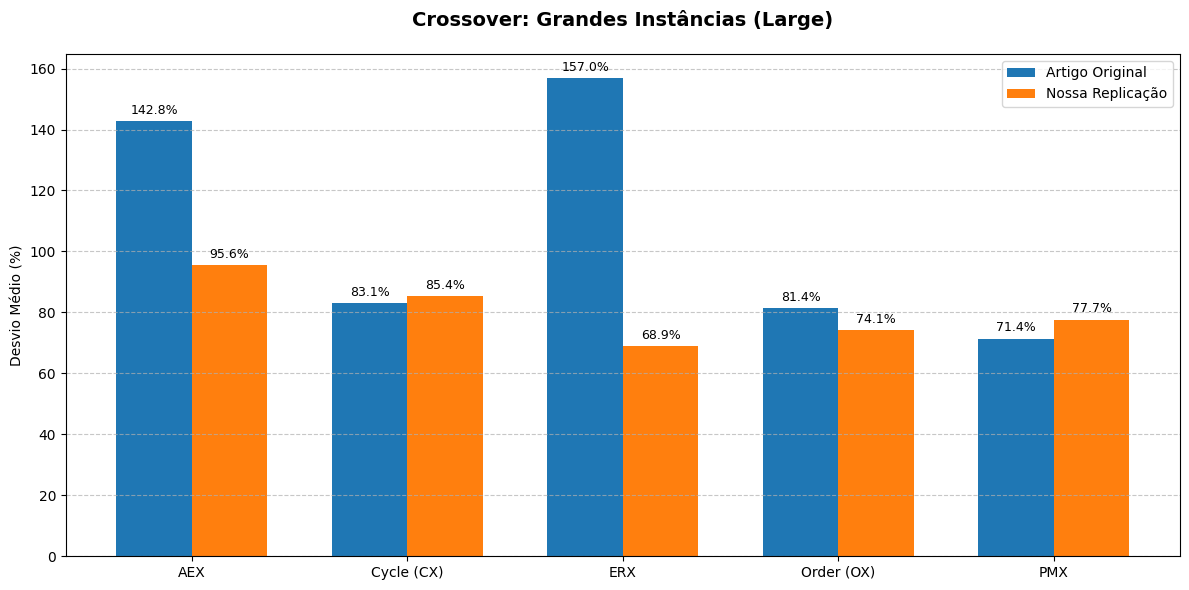

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Função para criar os gráficos de barras agrupadas
def plot_comparison(categories, data_article, data_ours, title, ylabel, filename):
    x = np.arange(len(categories))  # Localização dos rótulos
    width = 0.35  # Largura das barras

    fig, ax = plt.subplots(figsize=(12, 6)) # Aumentei um pouco a largura
    rects1 = ax.bar(x - width/2, data_article, width, label='Artigo Original', color='#1f77b4')
    rects2 = ax.bar(x + width/2, data_ours, width, label='Nossa Replicação', color='#ff7f0e')

    # Adicionar textos, título e rótulos
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adicionar rótulos de valor em cima das barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.savefig(filename, dpi=300) # Salva em alta qualidade
    print(f"Gráfico salvo: {filename}")
    plt.show()

# ==========================================
# DEFINIÇÃO DOS DADOS
# ==========================================

selecoes = ['Elitismo', 'Rank', 'Roleta', 'Torneio']
crossovers = ['AEX', 'Cycle (CX)', 'ERX', 'Order (OX)', 'PMX']

# --- 1. PEQUENAS INSTÂNCIAS (SMALL) ---
# Seleção
sel_artigo_small = [16.85, 18.97, 16.87, 17.14]
sel_nosso_small  = [24.38, 35.73, 15.34, 16.53]

# Crossover
cross_artigo_small = [14.69, 20.41, 12.88, 20.26, 19.04]
cross_nosso_small  = [25.69, 26.09, 15.46, 22.72, 24.78]

# --- 2. MÉDIAS INSTÂNCIAS (MEDIUM) ---
# Seleção
sel_artigo_medium = [63.87, 58.05, 66.18, 58.05]
sel_nosso_medium  = [37.48, 78.89, 31.63, 29.73]

# Crossover
cross_artigo_medium = [74.92, 49.72, 82.42, 50.68, 49.95]
cross_nosso_medium  = [51.30, 50.61, 32.82, 43.70, 43.73]

# --- 3. GRANDES INSTÂNCIAS (LARGE) ---
# Seleção
sel_artigo_large = [111.74, 104.95, 109.40, 103.31]
sel_nosso_large  = [58.19, 142.55, 65.68, 54.95]

# Crossover
cross_artigo_large = [142.79, 83.13, 157.00, 81.43, 71.40]
cross_nosso_large  = [95.59, 85.42, 68.94, 74.13, 77.65]

# ==========================================
# GERAÇÃO DOS GRÁFICOS
# ==========================================

# 1. SMALL
plot_comparison(selecoes, sel_artigo_small, sel_nosso_small,
               'Seleção: Pequenas Instâncias (Small)',
               'Desvio Médio (%)', 'selecao_small.png')

plot_comparison(crossovers, cross_artigo_small, cross_nosso_small,
               'Crossover: Pequenas Instâncias (Small)',
               'Desvio Médio (%)', 'crossover_small.png')

# 2. MEDIUM
plot_comparison(selecoes, sel_artigo_medium, sel_nosso_medium,
               'Seleção: Médias Instâncias (Medium)',
               'Desvio Médio (%)', 'selecao_medium.png')

plot_comparison(crossovers, cross_artigo_medium, cross_nosso_medium,
               'Crossover: Médias Instâncias (Medium)',
               'Desvio Médio (%)', 'crossover_medium.png')

# 3. LARGE
plot_comparison(selecoes, sel_artigo_large, sel_nosso_large,
               'Seleção: Grandes Instâncias (Large)',
               'Desvio Médio (%)', 'selecao_large.png')

plot_comparison(crossovers, cross_artigo_large, cross_nosso_large,
               'Crossover: Grandes Instâncias (Large)',
               'Desvio Médio (%)', 'crossover_large.png')

In [ ]:
FUNÇÃO Split_Guloso(Lista_Clientes):
    Caminhao = 0
    Rotas = []
    Rota_Atual = [Deposito]

    PARA CADA Cliente NA Lista_Clientes:
        Demanda = Obter_Demanda(Cliente)

        # Se estourar a capacidade, volta pro depósito
        SE (Caminhao + Demanda > Capacidade_Maxima):
            Rota_Atual.adicionar(Deposito)
            Rotas.adicionar(Rota_Atual)

            # Inicia nova rota com o cliente atual
            Rota_Atual = [Deposito, Cliente]
            Caminhao = Demanda
        SENÃO:
            Rota_Atual.adicionar(Cliente)
            Caminhao += Demanda

    Rota_Atual.adicionar(Deposito) # Fecha última rota
    RETORNAR Custo_Total(Rotas)